# Disaggregation of appliances from generated load profiles

## Open questions:
- Does an appliance count as 'on' if it is active at _any_ time within a given window?

In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam

pd.set_option("display.precision", 10)
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
df = pd.read_csv("data/14_days/data_reduced.csv", index_col=0)
df

c:\users\allen\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Electricity.Timestep,Time,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine,Target
0,0,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-01-01 00:00:01,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-01-01 00:00:02,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-01-01 00:00:03,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-01-01 00:00:04,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1048570,1048570,2021-01-13 03:16:10,0.0,0.0,0.0,0.0,0.0,0.0
1048571,1048571,2021-01-13 03:16:11,0.0,0.0,0.0,0.0,0.0,0.0
1048572,1048572,2021-01-13 03:16:12,0.0,0.0,0.0,0.0,0.0,0.0
1048573,1048573,2021-01-13 03:16:13,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
appliances = ["Stove", "Coffee_machine", "Microwave", "Dishwasher", "Washing_machine"]

<AxesSubplot:>

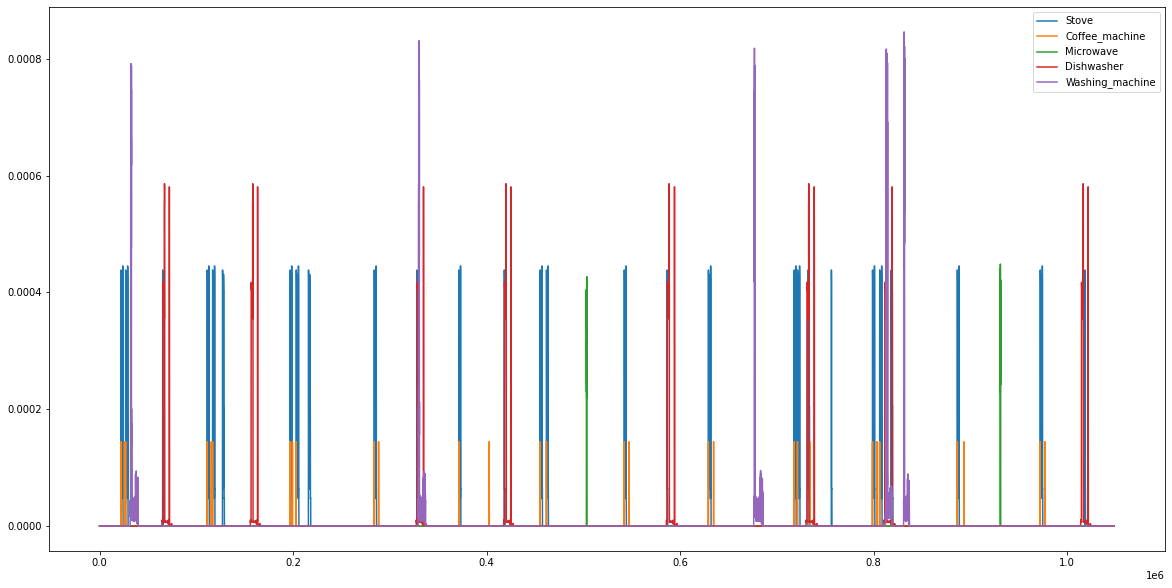

In [4]:
df.plot(y=appliances, figsize=(20,10))

<AxesSubplot:>

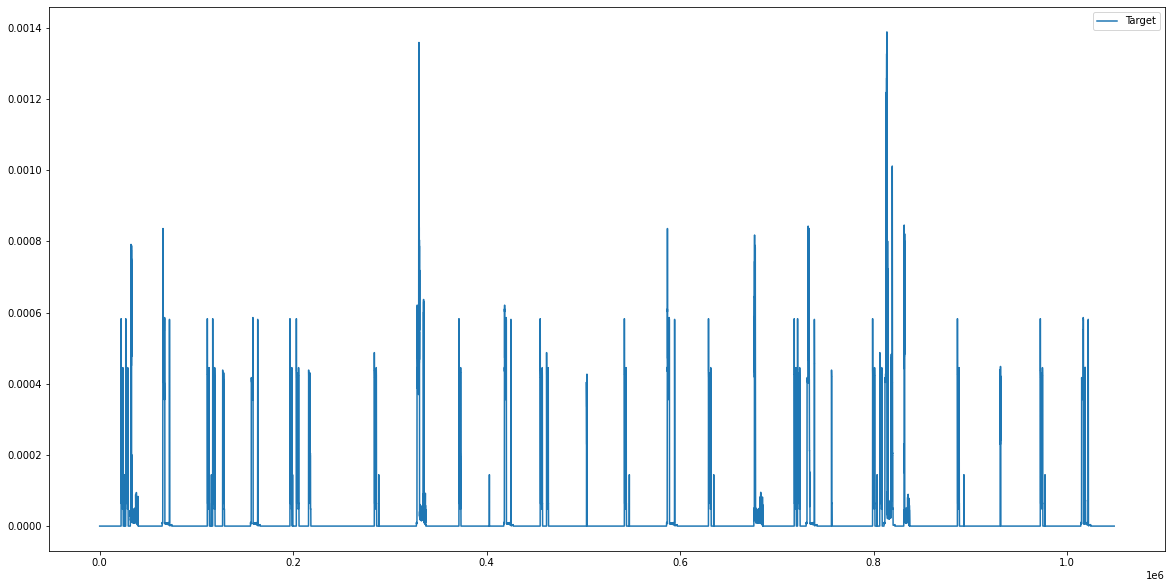

In [5]:
df.plot(y=["Target"], figsize=(20,10))

## Create rolling window

In [6]:
# first entry
df.iloc[[22173]]

,Electricity.Timestep,Time,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine,Target
22173,22173,2021-01-01 06:09:33,0.0004384159,0.0,0.0,0.0,0.0,0.0004384159


In [7]:
"""
returns the label vector
a device is 'on' if at any time within the timeframe it is running
"""
def create_label_vector(df, start, end):
    target_vector = np.zeros(len(appliances))
    for i in range(start, end):
        for idx, x in enumerate(df.columns):
            if x not in appliances:
                continue
            else:
                if df[x][i] > 0:
                    target_vector[appliances.index(x)] = 1
    return target_vector

In [8]:
def create_rolling(df, arr, window_size, step, start=0, drop_zero=True):
    windows = list()
    targets = list()
    arr_length = len(arr)
    
    if window_size >= arr_length:
        raise Exception("Window size is larger than given array")
    
    while start < arr_length - 1:
        end = start + window_size
        current_window = arr[start:end]
        if len(current_window) == window_size:
            if drop_zero and not all(entries == 0 for entries in current_window):
                targets.append(create_label_vector(df, start, end))
                windows.append(current_window)
        start = start + step
        
    return windows, targets

### Test

In [9]:
window_size = 60
step = 1

# Convert time series data to windowed data frame

In [10]:
def create_timeseries_dataframe(data, window_size):
    windows, targets = create_rolling(df=data, arr=list(data["Target"]), window_size=window_size, step=step)
    column_names_samples = [f"sample_{i}" for i in list(range(window_size))]
    column_names = column_names_samples + appliances
    merged = []
    for i in range(len(windows)):
        merged.append(list(np.array(windows[i])) + list(np.array(targets[i])))
    df_timeseries = pd.DataFrame(data=merged, columns=column_names)
    return df_timeseries

In [11]:
df_timeseries = create_timeseries_dataframe(df, window_size)
df_timeseries[appliances] = df_timeseries[appliances].astype(int)
df_timeseries

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,sample_37,sample_38,sample_39,sample_40,sample_41,sample_42,sample_43,sample_44,sample_45,sample_46,sample_47,sample_48,sample_49,sample_50,sample_51,sample_52,sample_53,sample_54,sample_55,sample_56,sample_57,sample_58,sample_59,Stove,Coffee_machine,Microwave,Dishwasher,Washing_machine
0,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0004876085,1,1,0,0,0
1,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000000,0.0000000000,0.0000000000,0.0004876085,0.0004876085,1,1,0,0,0
2,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000000,0.0000000000,0.0004876085,0.0004876085,0.0004876085,1,1,0,0,0
3,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000000,0.0004876085,0.0004876085,0.0004876085,0.0004876085,1,1,0,0,0
4,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0004876085,0.0004876085,0.0004876085,0.0004876085,0.0004876085,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157981,0.000004265,0.000004265,0.000004265,0.000004265,0.000004265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0,0,0,1,0
157982,0.000004265,0.000004265,0.000004265,0.000004265,0.000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0,0,0,1,0
157983,0.000004265,0.000004265,0.000004265,0.000000000,0.000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0,0,0,1,0
157984,0.000004265,0.000004265,0.000000000,0.000000000,0.000000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0,0,0,1,0


# Train-test split

In [12]:
samples = [x for i,x in enumerate(df_timeseries.columns) if x not in appliances]
X = df_timeseries.loc[:, samples]
y = df_timeseries.loc[:, appliances]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, shuffle=False)

# Modeling

In [15]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [16]:
X_train.shape

(107429, 60)

In [17]:
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [277]:
EPOCHS = 25
BATCH_SIZE = 32

callbacks = [
#    keras.callbacks.ReduceLROnPlateau(
#        monitor="val_loss", factor=0.5, patience=20, min_lr=0.001
#    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1, restore_best_weights=True),
]

In [278]:
from keras.layers import *
def create_model():
    input_layer = keras.layers.Input(shape=(window_size, 1))
    
    conv1 = keras.layers.Conv1D(filters=32, kernel_size=5, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    #conv2 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv1)
    #conv2 = keras.layers.BatchNormalization()(conv2)
    #conv2 = keras.layers.ReLU()(conv2)
    
    #conv3 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv2)
    #conv3 = keras.layers.BatchNormalization()(conv3)
    #conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv1)
    
   # dense1 = keras.layers.Dense(128)(gap)
   # dense1 = keras.layers.BatchNormalization()(dense1)
   # dense1 = keras.layers.ReLU()(dense1)

    output_layer = keras.layers.Dense(len(appliances), activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [279]:
model = create_model()

In [280]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [281]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [282]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['AUC'])

In [283]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 60, 1)]           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 60, 32)            192       
                                                                 
 batch_normalization_25 (Bat  (None, 60, 32)           128       
 chNormalization)                                                
                                                                 
 re_lu_25 (ReLU)             (None, 60, 32)            0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_17 (Dense)            (None, 5)                 165

In [285]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS)

Epoch 1/25
3358/3358 [==============================] - 25s 7ms/step - loss: 0.3555 - auc: 0.8714 - val_loss: 3.8803 - val_auc: 0.7229
Epoch 2/25
3358/3358 [==============================] - 23s 7ms/step - loss: 0.3349 - auc: 0.8886 - val_loss: 4.6246 - val_auc: 0.4920
Epoch 3/25
3358/3358 [==============================] - 24s 7ms/step - loss: 0.3328 - auc: 0.8899 - val_loss: 16.5778 - val_auc: 0.6337
Epoch 4/25
3358/3358 [==============================] - 23s 7ms/step - loss: 0.3303 - auc: 0.8915 - val_loss: 22.8514 - val_auc: 0.5246
Epoch 5/25
3358/3358 [==============================] - 23s 7ms/step - loss: 0.3287 - auc: 0.8925 - val_loss: 13.2744 - val_auc: 0.4315
Epoch 6/25
3358/3358 [==============================] - 24s 7ms/step - loss: 0.3292 - auc: 0.8924 - val_loss: 52.3938 - val_auc: 0.6337
Epoch 7/25
3358/3358 [==============================] - 24s 7ms/step - loss: 0.3267 - auc: 0.8941 - val_loss: 14.0910 - val_auc: 0.6337
Epoch 8/25
3358/3358 [============================

In [286]:
y_pred = model.predict(X_test)
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

In [287]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

988/988 [==============================] - 4s 4ms/step - loss: 65.2358 - auc: 0.4329
Test accuracy 0.43291783332824707
Test loss 65.2358169555664


In [288]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.0

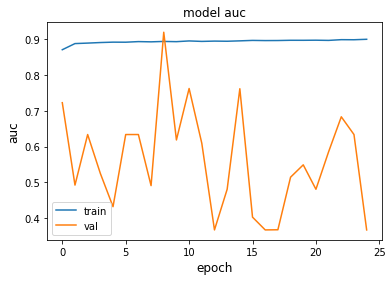

In [289]:
metric = "auc"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [290]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
mcm = multilabel_confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=appliances, zero_division=False))

                 precision    recall  f1-score   support

          Stove       0.23      1.00      0.37      7202
 Coffee_machine       0.02      1.00      0.03       477
      Microwave       0.00      0.00      0.00       713
     Dishwasher       0.00      0.00      0.00     19878
Washing_machine       0.40      1.00      0.57     12688

      micro avg       0.22      0.50      0.30     40958
      macro avg       0.13      0.60      0.19     40958
   weighted avg       0.16      0.50      0.24     40958
    samples avg       0.22      0.48      0.29     40958



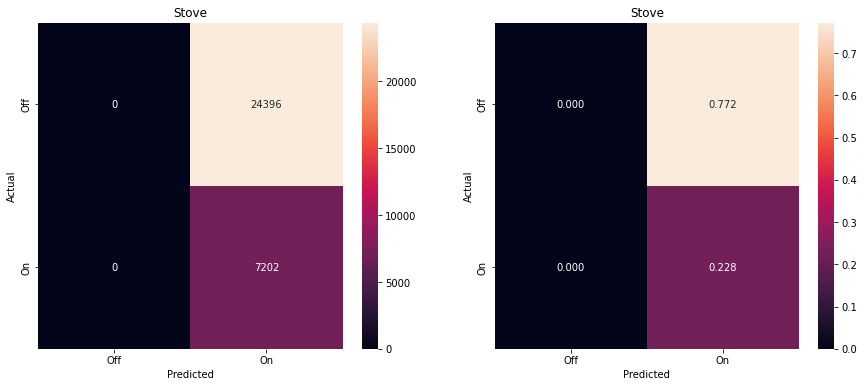

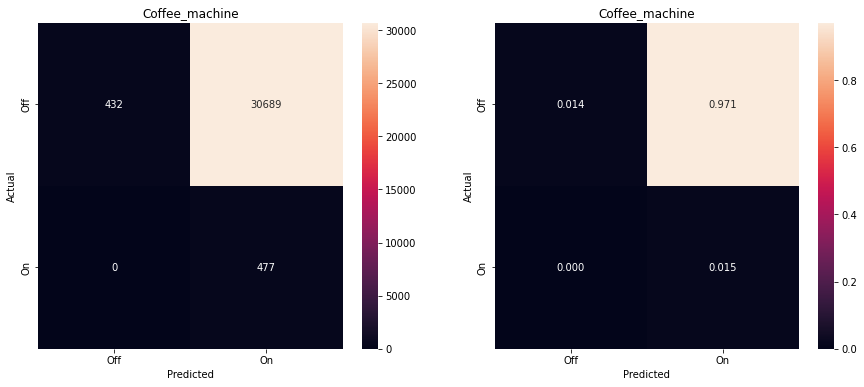

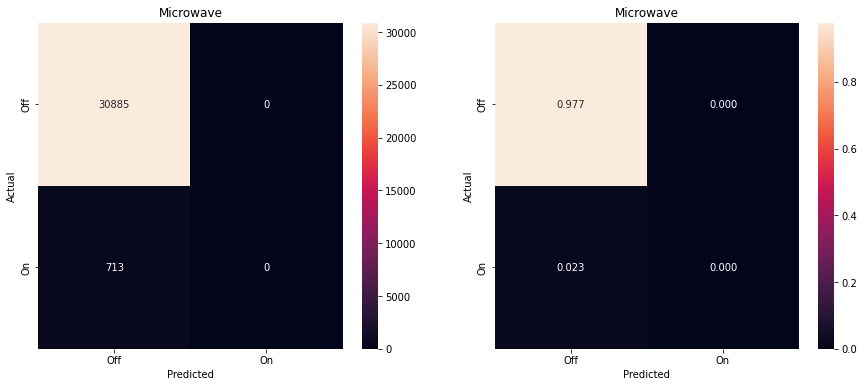

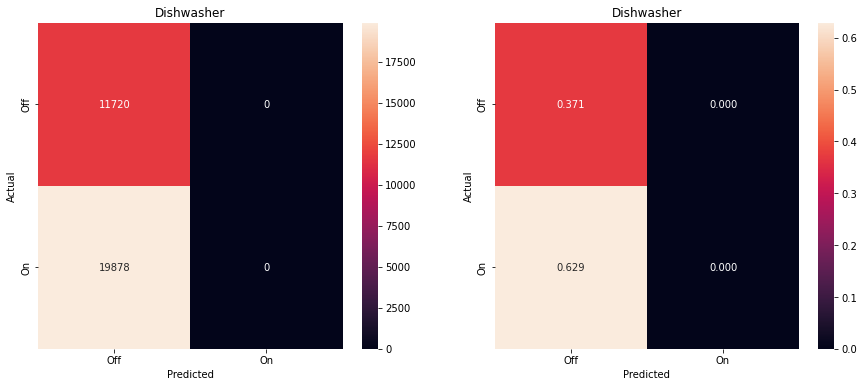

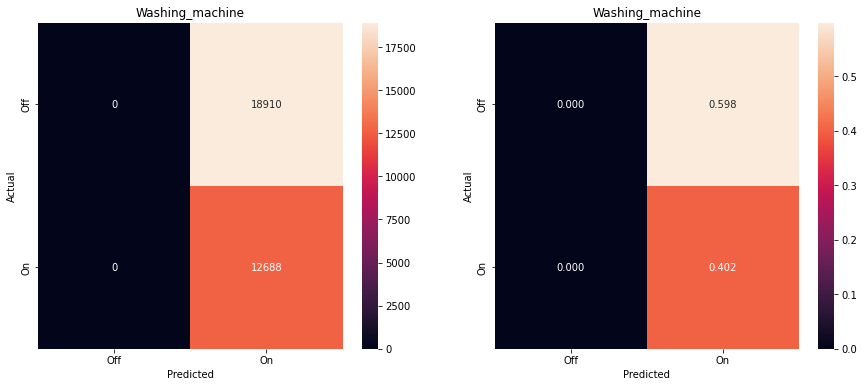

In [291]:
columns=["Off", "On"]
for idx, item in enumerate(mcm):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    heat = sns.heatmap(item, annot=True, fmt="1", xticklabels=columns, yticklabels=columns, ax=ax1)
    norm_item = item.astype('float') / item.sum(axis=None)
    norm_heat = sns.heatmap(norm_item, annot=True, fmt=".3f", xticklabels=columns, yticklabels=columns, ax=ax2)
    for ax in [ax1, ax2]:
        ax.set_title(appliances[idx])
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    plt.show()